In [10]:
## basic modules
import os
import sys
import re
import xarray as xr
import glob
import numpy as np
import pandas as pd
import itertools ## need this for the cbarticks

## plotting modules
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## personal modules
sys.path.append('../cmap_toolkit') # point this to where you have the CW3E cmaps_toolkit repo located
from plotter import draw_basemap, plot_terrain
import domains
import cw3ecmaps as ccmaps

In [2]:
## TO DO - put this into a single function
path_to_data = '/data/downloaded/SCRATCH/cw3eit_scratch/'
fpath = path_to_data + 'GFS/'

## get the most recent file in the directory
list_of_files = glob.glob(fpath+'*.nc')
fname = max(list_of_files, key=os.path.getctime)

# pull the initialization date from the filename
regex = re.compile(r'\d+')
date_string = regex.findall(fname)
date_string = date_string[1]

## Forecast hour list
F_lst = np.arange(12, 120+12, 12) ## from 12 - 120 hours every 12 hours

## open the files with the correct forecast hour
ds_lst = []
for i, F in enumerate(F_lst):
    fname= fpath + 'GFS_IVT_{0}_F{1}.nc'.format(date_string, F)
    ds = xr.open_dataset(fname)
    ds = ds.rename({'lon_0': 'lon', 'lat_0': 'lat'}) # need to rename this to match GEFS
    ds_lst.append(ds)

## concat the dataset list into a single dataset
ds = xr.concat(ds_lst, pd.Index(F_lst, name="F"))
ds = ds.sel(F=12)
ds

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 281)
Coordinates:
  * lat      (lat) float32 10.0 10.25 10.5 10.75 11.0 ... 69.25 69.5 69.75 70.0
  * lon      (lon) float32 180.0 180.2 180.5 180.8 ... 249.2 249.5 249.8 250.0
    F        int64 12
Data variables:
    IVT      (lat, lon) float32 429.8 427.7 426.2 424.2 ... 64.72 60.81 57.6
    uIVT     (lat, lon) float32 -414.1 -411.7 -410.1 ... 64.37 60.42 57.38
    vIVT     (lat, lon) float32 -115.2 -115.6 -115.8 ... -6.723 -6.824 -5.033

In [3]:
## create list that has the start and end points for the cross section
lon_lst = np.arange(170., 245., 5.)
line_lst = []
for i, lon in enumerate(lon_lst):
    ## create list of lines where [start_lat, start_lon, end_lat, end_lon]
    line = [25., lon, 65., lon]
    line_lst.append(line)
    
print(line_lst)

current_line = [25., 185, 65., 185]

[[25.0, 170.0, 65.0, 170.0], [25.0, 175.0, 65.0, 175.0], [25.0, 180.0, 65.0, 180.0], [25.0, 185.0, 65.0, 185.0], [25.0, 190.0, 65.0, 190.0], [25.0, 195.0, 65.0, 195.0], [25.0, 200.0, 65.0, 200.0], [25.0, 205.0, 65.0, 205.0], [25.0, 210.0, 65.0, 210.0], [25.0, 215.0, 65.0, 215.0], [25.0, 220.0, 65.0, 220.0], [25.0, 225.0, 65.0, 225.0], [25.0, 230.0, 65.0, 230.0], [25.0, 235.0, 65.0, 235.0], [25.0, 240.0, 65.0, 240.0]]


In [7]:
## Set domain name
domain_name = 'nepacific'

## Set up data based on domain name
ext = domains.extent[domain_name]['ext']
dx = domains.extent[domain_name]['xticks']
dy = domains.extent[domain_name]['yticks']

datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = domains.extent[domain_name]['ccrs'] ## the projection you want your map displayed in

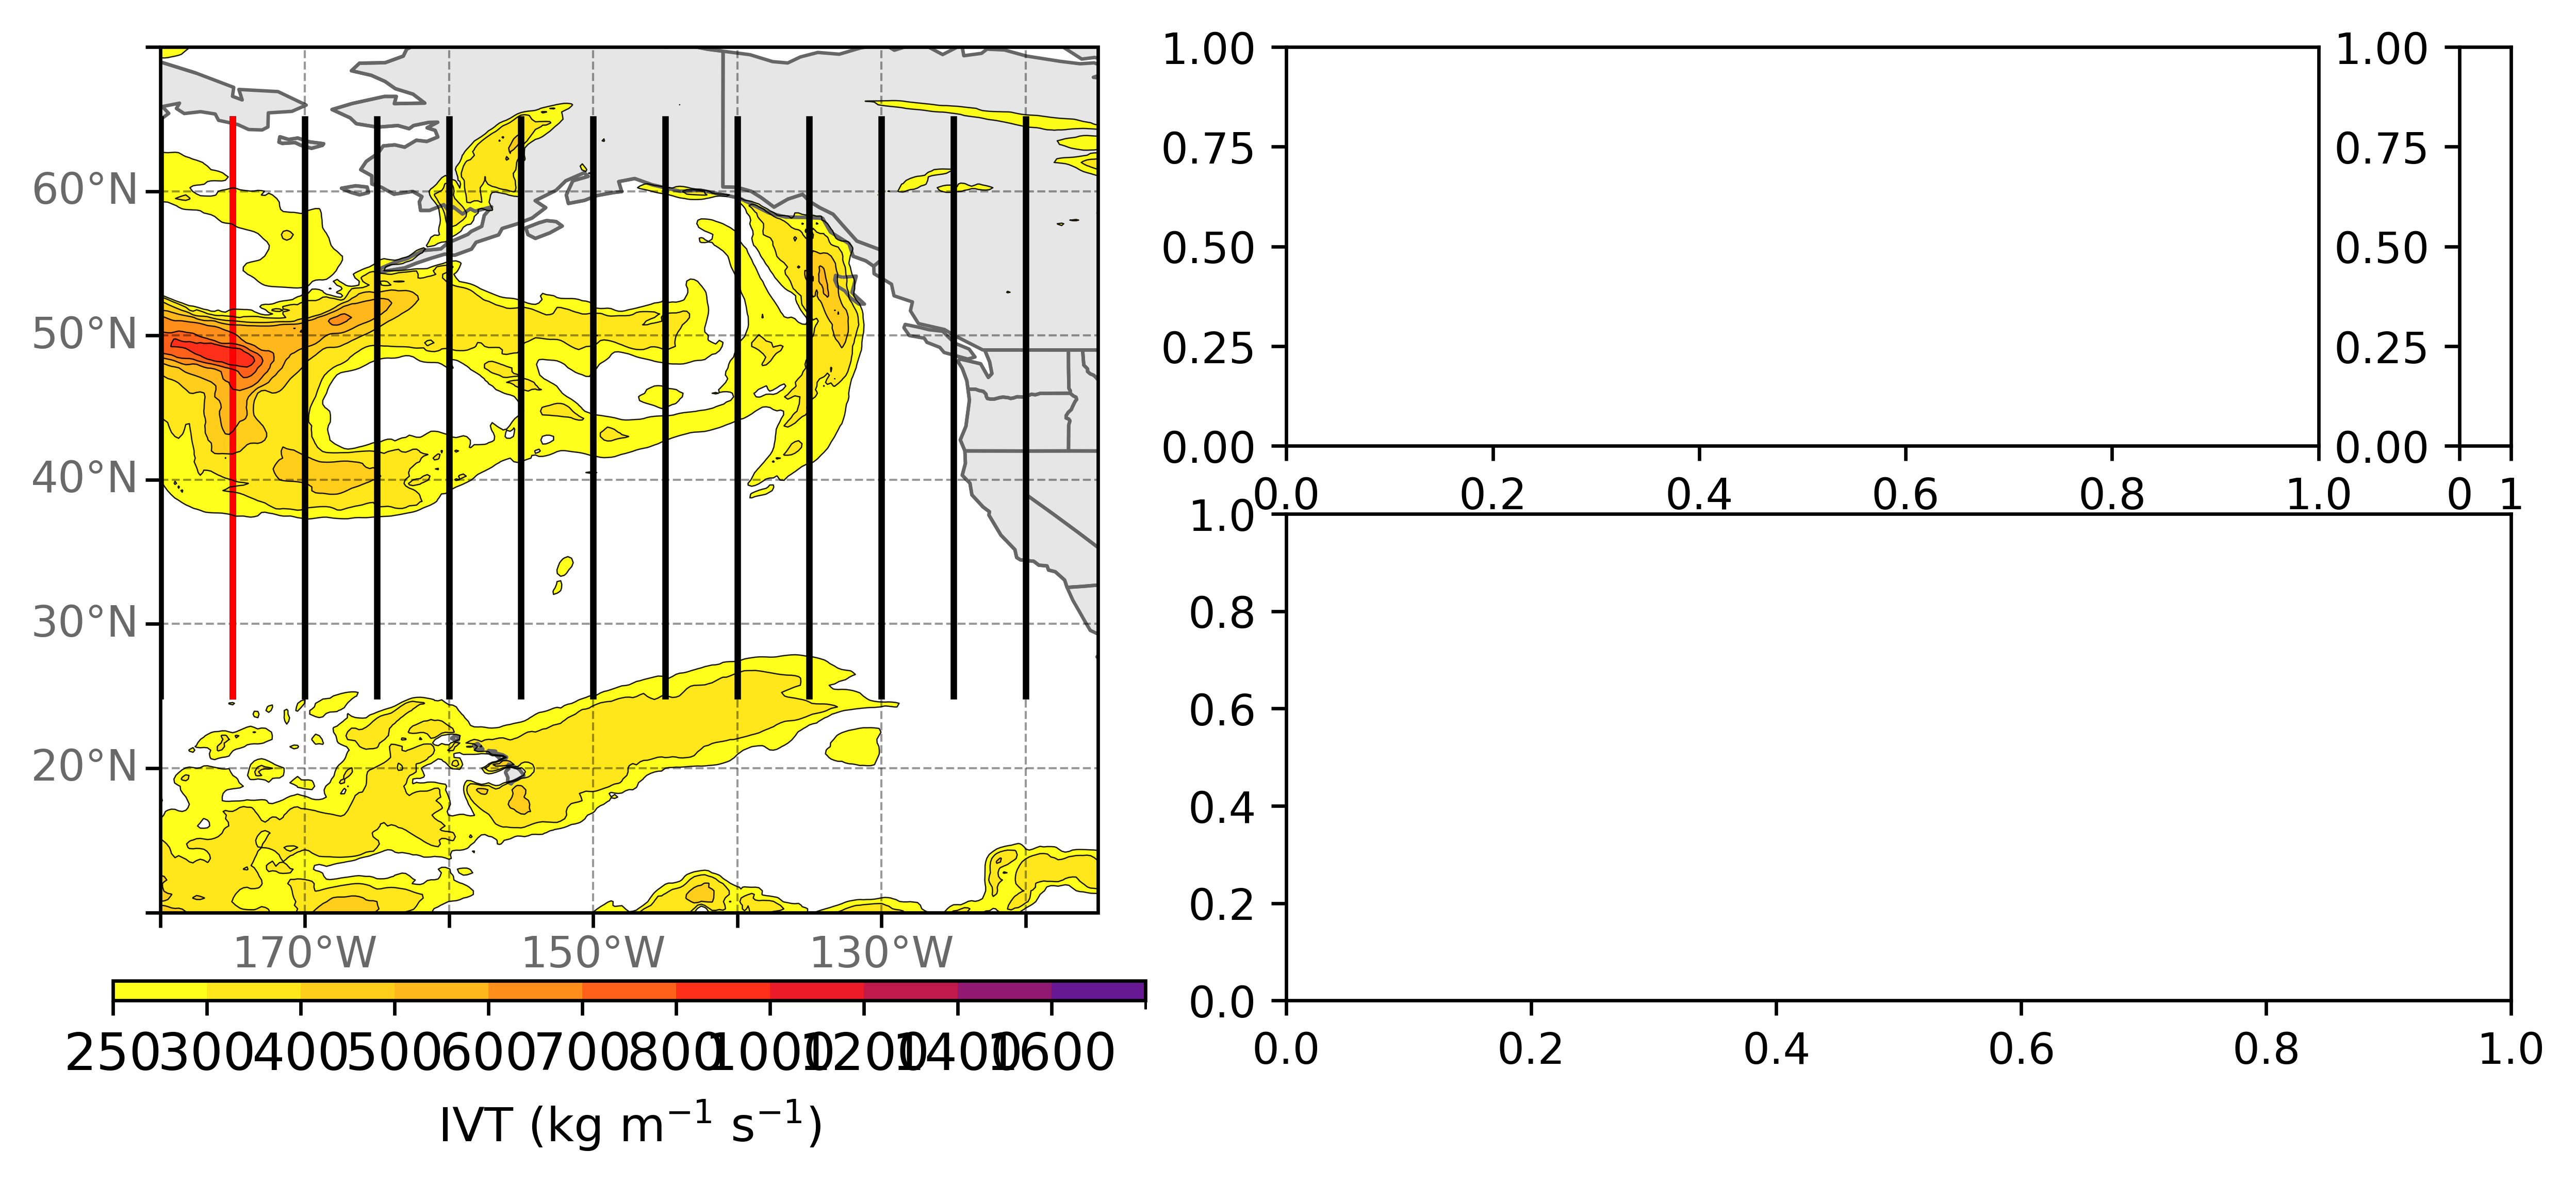

In [18]:
nrows = 3
ncols = 3
kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05], width_ratios = [1, 1, 0.05], wspace=0.2, hspace=0.25)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(10.0, 4.0))
fig.dpi = 600
fname = 'test'
fmt = 'png'

####################
### PLOT IVT MAP ###
####################

ax = fig.add_subplot(gs[0:2, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, grid=True)
ax.set_extent(ext, datacrs)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

## filled contour (IVT)
lats = ds.lat.values
lons = ds.lon.values
data = ds.IVT.values
cmap, norm, bnds, cbarticks, cbarlbl = ccmaps.cmap('ivt') # get cmap from our custom function

cf = ax.contourf(lons, lats, data, transform=datacrs, levels=bnds, cmap=cmap, norm=norm, alpha=0.9)

## contour lines (IVT)
cs = ax.contour(lons, lats, data, transform=datacrs, levels=bnds, colors=['black'], linewidths=0.3, alpha=0.9, zorder=100)

## black lines where possible cross sections are
for i, line in enumerate(line_lst):
    ax.plot([line[1], line[3]], [line[0], line[2]], color='k', transform=datacrs, zorder=3)
        
## red line where current cross section is showing
ax.plot([current_line[1], current_line[3]], [current_line[0], current_line[2]], color='r', transform=datacrs, zorder=3)

## color bar
cbax = fig.add_subplot(gs[-1, 0]) # colorbar axis (first row, last column)
cbarticks = list(itertools.compress(bnds, cbarticks)) ## this labels the cbarticks based on the cmap dictionary
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom', ticks=cbarticks)
cb.set_label(cbarlbl, fontsize=11)
cb.ax.tick_params(labelsize=12)

#####################
### CROSS SECTION ###
#####################
ax = fig.add_subplot(gs[0, 1])

# ## y-axis is pressure
# ## x-axis are the points

# xs = np.arange(0, len(test.location), 1) # how many coordinate values
# ys = wv_flux.level.values
# # terline = test.values
# terline = sp.sp.values / 100
# ht_fill = ax.fill_between(xs, 1000, terline, facecolor='0.9', edgecolor='k', zorder=10)

# # Filled contours (WV flux)
# cflevs = np.arange(0.02, 0.20, 0.02)
# clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
# cf = ax.contourf(xs, ys, wv_flux.values, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)
# plt.gca().invert_yaxis()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
# ax.set_ylabel("Pressure (hPa)", fontsize=11)

# ## add trajectory point
# x = 9
# y = ds.level.values[0][0][29]
# ax.scatter(x, y, c='k', marker='.',  alpha=1, s=40)

# ## add freezing level
# freeze_line = ax.plot(xs, deg0l, c='cyan', lw=1.5)

# x_ticks = np.arange(len(xs))
# x_labels = [u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(wv_flux.latitude.values[i], wv_flux.longitude.values[i]*-1) for i in x_ticks]
# # set the frequency of xtick labels
# skip = 5
# ax.set_xticks(x_ticks[0::skip])
# ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[0::skip]], fontsize=6, **kw_ticklabels)

# # Add color bar
cbax = fig.add_subplot(gs[0, -1]) # colorbar axis
# # cbarticks = norm[::1]
# cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
# cb.set_label('WV Flux (m s$^{-1}$)', fontsize=11)
# cb.ax.tick_params(labelsize=12)

###################
### TIME SERIES ###
###################
ax = fig.add_subplot(gs[1:, 1:])

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()